In [1]:
import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import visualkeras
import cv2
import os
import time
import numpy as np
import copy
from cityscapesscripts.helpers.labels import labels

In [2]:
def build_model(input_shape, output_classes):
    inputs = Input(input_shape)

    conv_1 = Conv2D(16, (2, 2), padding='same')(inputs)
    conv_1 = LeakyReLU(0.2)(conv_1)
    conv_1 = Conv2D(16, (2, 2), padding='same')(conv_1)
    conv_1 = LeakyReLU(0.2)(conv_1)
    pool_1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_1)

    conv_2 = Conv2D(32, (2, 2), padding='same')(pool_1)
    conv_2 = LeakyReLU(0.2)(conv_2)
    conv_2 = Conv2D(32, (2, 2), padding='same')(conv_2)
    conv_2 = LeakyReLU(0.2)(conv_2)
    pool_2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_2)

    conv_3 = Conv2D(64, (2, 2), padding='same')(pool_2)
    conv_3 = LeakyReLU(0.2)(conv_3)
    conv_3 = Conv2D(64, (2, 2), padding='same')(conv_3)
    conv_3 = LeakyReLU(0.2)(conv_3)
    pool_3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_3)

    conv_4 = Conv2D(128, (2, 2), padding='same')(pool_3)
    conv_4 = LeakyReLU(0.2)(conv_4)
    conv_4 = Conv2D(128, (2, 2), padding='same')(conv_4)
    conv_4 = LeakyReLU(0.2)(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_4)

    conv_5 = Conv2D(256, (2, 2), padding='same')(pool_4)
    conv_5 = LeakyReLU(0.2)(conv_5)
    conv_5 = Conv2D(256, (2, 2), padding='same')(conv_5)
    conv_5 = LeakyReLU(0.2)(conv_5)


    pool_5 = UpSampling2D(size=(2,2))(conv_5)
    concat_1 = tf.concat([pool_5, conv_4], axis=-1)
    conv_6 = Conv2DTranspose(384, (2, 2), padding='same')(concat_1)
    conv_6 = LeakyReLU(0.2)(conv_6)
    conv_6 = Conv2DTranspose(128, (2, 2), padding='same')(conv_6)
    conv_6 = LeakyReLU(0.2)(conv_6)

    pool_6 = UpSampling2D(size=(2,2))(conv_6)
    concat_2 = tf.concat([pool_6, conv_3], axis=-1)
    conv_7 = Conv2DTranspose(192, (2, 2), padding='same')(concat_2)
    conv_7 = LeakyReLU(0.2)(conv_7)
    conv_7 = Conv2DTranspose(64, (2, 2), padding='same')(conv_7)
    conv_7 = LeakyReLU(0.2)(conv_7)

    pool_7 = UpSampling2D(size=(2,2))(conv_7)
    concat_3 = tf.concat([pool_7, conv_2], axis=-1)
    conv_8 = Conv2DTranspose(96, (2, 2), padding='same')(concat_3)
    conv_8 = LeakyReLU(0.2)(conv_8)
    conv_8 = Conv2DTranspose(32, (2, 2), padding='same')(conv_8)
    conv_8 = LeakyReLU(0.2)(conv_8)

    pool_8 = UpSampling2D(size=(2,2))(conv_8)
    concat_4 = tf.concat([pool_8, conv_1], axis=-1)
    conv_9 = Conv2DTranspose(96, (2, 2), padding='same')(concat_4)
    conv_9 = LeakyReLU(0.2)(conv_9)
    conv_9 = Conv2DTranspose(32, (2, 2), padding='same')(conv_9)
    conv_9 = LeakyReLU(0.2)(conv_9)

    outputs = Conv2D(output_classes, (2,2), padding='same', activation='softmax')(conv_9)

    model = tf.keras.Model(inputs, outputs)

    return model

In [3]:
def get_dirs_files(path):
    items = os.listdir(path)
    dirs = []
    files = []
    for item in items:
        if os.path.isfile(os.path.join(path, item)):
            files.append(item)
        elif os.path.isdir(os.path.join(path, item)):
            dirs.append(item)
            
    return dirs, files

In [4]:
# Loads all images recursively under path for one sublevel
def load_images(path, img_resolution=None):
    dirs, files = get_dirs_files(path)
    if not dirs:
        dirs = ['.']
    
    images = []
    dirs.sort()
    for each_dir in dirs:
        img_names = os.listdir(os.path.join(path, each_dir))
        img_names.sort()
        for each_img_name in img_names:
            img = cv2.imread(os.path.join(path, each_dir, each_img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img_resolution:
                img = cv2.resize(img, img_resolution, interpolation=cv2.INTER_NEAREST)
            images.append(img)
            
    return images        

In [5]:
def unique_colors(images):
    colors = []
    for each_image in images:
        for i in range(each_image.shape[0]):
            for j in range(each_image.shape[1]):
                if not colors:
                    colors.append(each_image[i, j, :])
                else:
                    is_unique = True
                    for each_color in colors:
                        # print(each_image[i, j, :])
                        # print(each_color)
                        # time.sleep(2)
                        if each_image[i, j, 0] == each_color[0] and each_image[i, j, 1] == each_color[1] and each_image[i, j, 2] == each_color[2]:
                            is_unique = False
                    if is_unique:
                        colors.append(each_image[i, j])

    return colors

In [6]:
def image2id(images, labels):
    images_ids = []
    for each_image in images:
        for i in range(each_image.shape[0]):
            for j in range(each_image.shape[1]):
                color = each_image[i,j]
                idx = 0
                for k in range(len(labels)):
                    if np.array_equal(color, labels[k].color):
                        idx = k
                each_image[i,j,0] = labels[idx].categoryId
        images_ids.append(each_image[:,:,0])
    return images_ids

In [252]:
a = np.array([[1,1,2,1],[1,1,1,1]])
b = np.array([5,7])
a[b==5] = [5,5,5,5]
a

array([[5, 5, 5, 5],
       [1, 1, 1, 1]])

In [7]:
images_x = load_images(os.path.join('cityscapesScripts', 'leftImg8bit', 'train', 'aachen'), (256,256))

In [8]:
len(images_x)

174

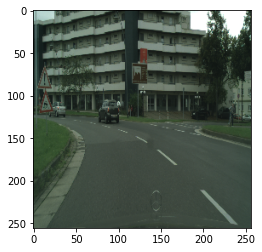

In [11]:
plt.imshow(images_x[0])

In [8]:
images_y = load_images(os.path.join('cityscapesScripts', 'gtFine', 'train_labels', 'aachen'), (256, 256))

In [23]:
images_z = load_images(os.path.join('cityscapesScripts', 'gtFine', 'train_trainlabels', 'aachen'), (256, 256))

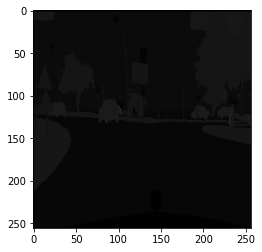

In [13]:
plt.imshow(images_y[0])

In [14]:
colors = unique_colors([images_y[0]])

In [15]:
print(len(colors))

15


In [9]:
model = build_model(images_y[0].shape, 35)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.categorical_accuracy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 208         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 1040        leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [26]:
unique_colors([images_z[0]])

[array([255, 255, 255], dtype=uint8),
 array([10, 10, 10], dtype=uint8),
 array([5, 5, 5], dtype=uint8),
 array([2, 2, 2], dtype=uint8),
 array([8, 8, 8], dtype=uint8),
 array([7, 7, 7], dtype=uint8),
 array([13, 13, 13], dtype=uint8),
 array([12, 12, 12], dtype=uint8),
 array([18, 18, 18], dtype=uint8),
 array([11, 11, 11], dtype=uint8),
 array([1, 1, 1], dtype=uint8),
 array([9, 9, 9], dtype=uint8),
 array([0, 0, 0], dtype=uint8)]

In [10]:
model.fit(np.array(images_x), tf.one_hot(np.array(images_y)[:,:,:,0], depth=35), validation_split=0.7, epochs=1000)

Epoch 1/1000
2/2 [==============================] - 108s 54s/step - loss: 8.0061 - categorical_accuracy: 0.0193 - val_loss: 4.2836 - val_categorical_accuracy: 0.3750
Epoch 2/1000
2/2 [==============================] - 1s 632ms/step - loss: 4.1381 - categorical_accuracy: 0.3169 - val_loss: 3.7239 - val_categorical_accuracy: 0.3438
Epoch 3/1000
2/2 [==============================] - 1s 617ms/step - loss: 3.5558 - categorical_accuracy: 0.3304 - val_loss: 2.8047 - val_categorical_accuracy: 0.3794
Epoch 4/1000
2/2 [==============================] - 1s 617ms/step - loss: 2.7882 - categorical_accuracy: 0.2935 - val_loss: 2.8351 - val_categorical_accuracy: 0.2162
Epoch 5/1000
2/2 [==============================] - 1s 619ms/step - loss: 2.6518 - categorical_accuracy: 0.2877 - val_loss: 2.5626 - val_categorical_accuracy: 0.4252
Epoch 6/1000
2/2 [==============================] - 1s 673ms/step - loss: 2.4315 - categorical_accuracy: 0.4086 - val_loss: 2.4547 - val_categorical_accuracy: 0.4458
Epoc

KeyboardInterrupt: 

In [13]:
pred_images = model.predict(np.array(images_x))

In [14]:
pred_images.shape

(174, 256, 256, 35)

In [17]:
tf.argmax(pred_images[0], axis=2)

<tf.Tensor: shape=(256, 256), dtype=int64, numpy=
array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  6,  6, ..., 21, 21, 21],
       ...,
       [ 3,  7,  7, ...,  7,  7,  7],
       [ 3,  7,  7, ...,  7,  7,  7],
       [ 3,  3,  3, ...,  3,  3,  3]])>

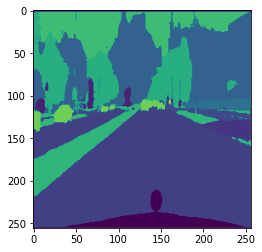

In [29]:
plt.imshow(tf.argmax(pred_images[1], axis=2))

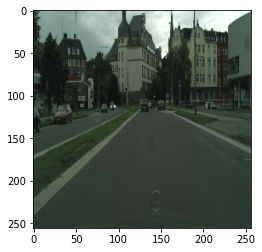

In [30]:
plt.imshow(images_x[1])

In [32]:
colors = []
ids = []
cat_ids = []
for label in labels:
    colors.append(label.color)
    ids.append(label.id)
    cat_ids.append(label.categoryId)

In [34]:
print(colors)
print(ids)
print(cat_ids)

[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), (0, 0, 142), (0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), (0, 0, 142)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, -1]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [49]:
np.unique(pred_images[0] == 0)

array([False,  True])

In [164]:
img = np.array(tf.argmax(pred_images[1], axis=2))

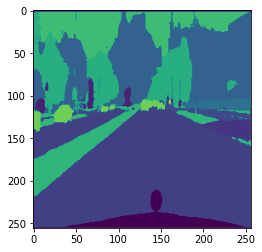

In [165]:
plt.imshow(img)

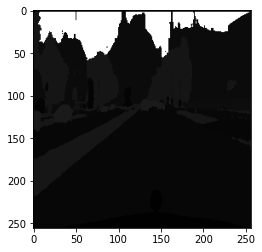

In [175]:
plt.imshow(img2)

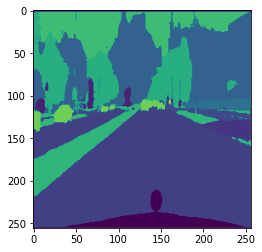

In [170]:
plt.imshow(img3)

In [171]:
print(np.unique(img))
mask = np.array(img == 23)
print(np.unique(mask))
img2 = np.repeat(np.expand_dims(img, axis=2), 3, axis=2)
print(mask.shape)
print(img2.shape)

[ 1  3  4  5  6  7  8 11 12 13 17 20 21 22 23 24 26 33]
[False  True]
(256, 256)
(256, 256, 3)


In [167]:
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ...  True False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [174]:
img2 = np.array(img2)
img2[mask] = [255,255,255]
print(np.unique(img2))
print(img)
print(img2)

[  1   3   4   5   6   7   8  11  12  13  17  20  21  22  24  26  33 255]
[[ 3  3  3 ...  3  3  3]
 [ 3  3  3 ...  3  3  3]
 [ 3  3 21 ... 23 11 11]
 ...
 [ 3  7  7 ...  7  7  7]
 [ 3  7  7 ...  7  7  7]
 [ 3  3  3 ...  3  3  3]]
[[[  3   3   3]
  [  3   3   3]
  [  3   3   3]
  ...
  [  3   3   3]
  [  3   3   3]
  [  3   3   3]]

 [[  3   3   3]
  [  3   3   3]
  [  3   3   3]
  ...
  [  3   3   3]
  [  3   3   3]
  [  3   3   3]]

 [[  3   3   3]
  [  3   3   3]
  [ 21  21  21]
  ...
  [255 255 255]
  [ 11  11  11]
  [ 11  11  11]]

 ...

 [[  3   3   3]
  [  7   7   7]
  [  7   7   7]
  ...
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]]

 [[  3   3   3]
  [  7   7   7]
  [  7   7   7]
  ...
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]]

 [[  3   3   3]
  [  3   3   3]
  [  3   3   3]
  ...
  [  3   3   3]
  [  3   3   3]
  [  3   3   3]]]


In [161]:
a = np.array([[1,1,1,2],[2,2,3,3]])
print(a.shape)
b = np.expand_dims(a, axis=-1)
print(b.shape)
c = np.repeat(b, 3, axis=2)
print(c.shape)
d = a
d[d==2]=5
print(d)

(2, 4)
(2, 4, 1)
(2, 4, 3)
[[1 1 1 5]
 [5 5 3 3]]


In [212]:
preds = model.predict(np.array(images_x))
preds.shape

(174, 256, 256, 35)

In [213]:
preds = np.array(tf.argmax(preds, axis=-1))
print(preds.shape)

(174, 256, 256)


In [254]:
def id2image(images_ids, ids, colors):
    images = copy.deepcopy(images_ids)
    images = np.expand_dims(images, axis=-1)
    images = np.repeat(images, 3, axis=-1)
    ids = np.array(ids)
    
    for i in range(len(colors)):
        images[images_ids==ids[i]] = np.array(colors[i])
    
    return images        

In [255]:
pred_color = id2image(preds, ids, colors)

In [256]:
pred_color.shape

(174, 256, 256, 3)

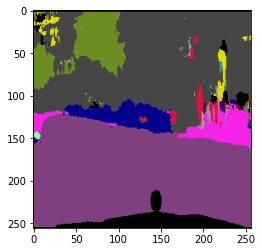

In [259]:
plt.imshow(pred_color[100])

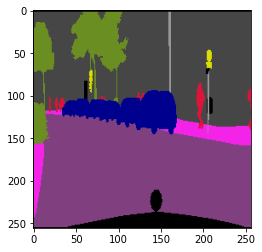

In [271]:
plt.imshow(images_y_color[100])

In [269]:
images_y_color = id2image(np.array(images_y)[:,:,:,0], ids, colors)

In [270]:
images_y_color.shape

(174, 256, 256, 3)